[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/keisen/tf-keras-vis/blob/master/examples/visualize_conv_filters.ipynb)

When you haven't yet installed `tf-keras-vis` in your environment, please run the cell below.

In [1]:
# !pip install --upgrade tf-keras-vis tensorflow matplotlib

(Please remove comment-out in the cell above when you want to install essential libraries to run tf-keras-vis.)

# Visualizing Conv filters using ActivationMaximization

### Load libraries

In [2]:
%reload_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus

_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

Tensorflow recognized 1 GPUs


### Load tf.keras.Model

This tutorial use VGG16 model in tf.keras but if you want to use other tf.keras.Models, you can do so by modifing section below.

In [3]:
from tensorflow.keras.applications.vgg16 import VGG16 as Model

# Load model
model = Model(weights='imagenet', include_top=True)
model.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

## Visualizing a Conv filter

### Define a function to modify the model

First, you MUST define a modifier to replace the model output to target layer's output that has filters you want to visualize.

In [4]:
layer_name = 'block5_conv3' # The target layer that is the last layer of VGG16.

def model_modifier(current_model):
    target_layer = current_model.get_layer(name=layer_name)
    target_layer.activation = tf.keras.activations.linear
    new_model = tf.keras.Model(inputs=current_model.inputs,
                               outputs=target_layer.output)
    return new_model

### Create ActivationMaximization Instnace

When `clone` argument is True(default), the `model` will be cloned, so the `model` instance will be NOT modified, but it may take a while.
Here, because it does NOT need to do so, setting `False`.

In [5]:
from tf_keras_vis.activation_maximization import ActivationMaximization

activation_maximization = ActivationMaximization(model,
                                                 model_modifier,
                                                 clone=False)

### Define Score function

You MUST create `Score` instance or define `score function` that returns target scores. Here, it returns the value corresponding to 63th filter of `block5_conv3` layer. ActivationMaximization will maximize this filter values.

In [6]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_number = 63
score = CategoricalScore(filter_number)

# Instead of CategoricalScore object,
# you can define the scratch function such as below:
def score_function(output):
    return output[..., filter_number]

### Visualize

ActivationMaximization will maximize the model output value that is computed by the score function. Here, we try to visualize a convolutional filter.

Steps: 050	Scores: [[483.7265319824219]],	Regularizations: [('TotalVariation2D', [14.084457397460938]), ('Norm', [0.33344516158103943])]
Steps: 100	Scores: [[602.67431640625]],	Regularizations: [('TotalVariation2D', [13.983019828796387]), ('Norm', [0.3366961181163788])]
Steps: 150	Scores: [[608.44140625]],	Regularizations: [('TotalVariation2D', [13.923792839050293]), ('Norm', [0.3401860296726227])]
Steps: 200	Scores: [[581.8219604492188]],	Regularizations: [('TotalVariation2D', [14.331083297729492]), ('Norm', [0.34437650442123413])]


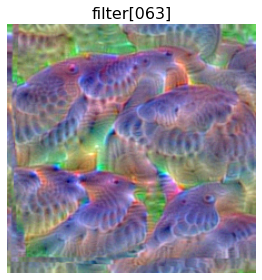

CPU times: user 12 s, sys: 854 ms, total: 12.8 s
Wall time: 12.8 s


In [7]:
%%time
from tf_keras_vis.activation_maximization.callbacks import PrintLogger as Logger
from tf_keras_vis.activation_maximization.callbacks import GifGenerator2D

# Generate maximized activation
activations = activation_maximization(score,
                                      callbacks=[Logger(interval=50)])

# Render
f, ax = plt.subplots(figsize=(4, 4))
ax.imshow(activations[0])
ax.set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
ax.axis('off')
plt.tight_layout()
plt.show()

## Visualizing Conv filters

Then, let's visualize multiple convolutional filters!

### Define Score function

When visualizing multiple convolutional filters, you MUST define Score function that return arbitrary filter values.

In [8]:
from tf_keras_vis.utils.scores import CategoricalScore

filter_numbers = [63, 132, 320]
score = CategoricalScore(filter_numbers)

### Create SeedInput values

And then, beforehand, you MUST create seed-input value. In default, when visualizing a conv filter, tf-keras-vis automatically generates seed-input. However when visualizing multiple conv filters at once, you MUST manually create seed-inputs.

In [9]:
# Define seed inputs whose shape is (samples, height, width, channels).

seed_input = tf.random.uniform((3, 224, 224, 3), 0, 255)

### Visualize

Here, we will visualize 3 images.

Steps: 050	Scores: [[450.3486022949219, 321.6353759765625, 505.47998046875]],	Regularizations: [('TotalVariation2D', [4.520468235015869, 3.935420036315918, 4.435067176818848]), ('Norm', [0.3323705792427063, 0.33292078971862793, 0.33724793791770935])]
Steps: 100	Scores: [[548.2874145507812, 427.218994140625, 612.2083740234375]],	Regularizations: [('TotalVariation2D', [4.765227317810059, 4.294017314910889, 5.010119915008545]), ('Norm', [0.3370225131511688, 0.3391658365726471, 0.34558814764022827])]
Steps: 150	Scores: [[595.4279174804688, 410.9785461425781, 644.6588134765625]],	Regularizations: [('TotalVariation2D', [5.0414228439331055, 4.517918109893799, 5.348117828369141]), ('Norm', [0.34122389554977417, 0.345319539308548, 0.35418692231178284])]
Steps: 200	Scores: [[660.8365478515625, 429.4980163574219, 724.73583984375]],	Regularizations: [('TotalVariation2D', [5.003698825836182, 4.413851737976074, 5.391910552978516]), ('Norm', [0.34523940086364746, 0.3498722314834595, 0.362011224031448

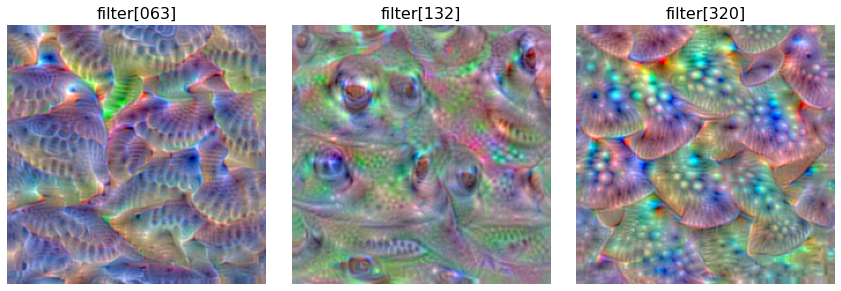

CPU times: user 20.6 s, sys: 302 ms, total: 20.9 s
Wall time: 22.9 s


In [10]:
%%time
# Generate maximized activations
activations = activation_maximization(score,
                                      seed_input=seed_input,
                                      callbacks=[Logger(interval=50)])
# Render
f, ax = plt.subplots(nrows=1, ncols=3, figsize=(12, 4))
for i, filter_number in enumerate(filter_numbers):
    ax[i].set_title('filter[{:03d}]'.format(filter_number), fontsize=16)
    ax[i].imshow(activations[i])
    ax[i].axis('off')
plt.tight_layout()
plt.savefig('images/visualize-filters')
plt.show()